In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split

# Image dimensions
img_height, img_width = 224, 224


train_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\training"
test_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\testing"

# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load training data from 'dataset/train' directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Load test data from 'dataset/test' directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Extract features and labels from the train generator
train_images, train_labels = next(train_generator)
for i in range(len(train_generator) - 1):
    img_batch, lbl_batch = next(train_generator)
    train_images = np.concatenate((train_images, img_batch), axis=0)
    train_labels = np.concatenate((train_labels, lbl_batch), axis=0)

# Display the shape of extracted data
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Train Images Shape: (8863, 224, 224, 3)
Train Labels Shape: (8863,)


In [3]:
# Split the train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, 
    test_size=0.2,              # here 20% of data will be used for validation
    random_state=42, 
    stratify=train_labels
)

print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")

X_train Shape: (7090, 224, 224, 3), y_train Shape: (7090,)
X_val Shape: (1773, 224, 224, 3), y_val Shape: (1773,)


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load VGG16 model + higher level layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_base.output)

# Extract VGG16 features
train_features_vgg = vgg_model.predict(X_train, verbose=1)
val_features_vgg = vgg_model.predict(X_val, verbose=1)
test_features_vgg = vgg_model.predict(test_generator, verbose=1)

# Flatten the VGG16 features
train_features_vgg = train_features_vgg.reshape(train_features_vgg.shape[0], -1)
val_features_vgg = val_features_vgg.reshape(val_features_vgg.shape[0], -1)
test_features_vgg = test_features_vgg.reshape(test_features_vgg.shape[0], -1)

print(f"Train Features Shape: {train_features_vgg.shape}")
print(f"Validation Features Shape: {val_features_vgg.shape}")
print(f"Test Features Shape: {test_features_vgg.shape}")


222/222 ━━━━━━━━━━━━━━━━━━━━ 1844s 8s/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step
Train Features Shape: (7090, 25088)
Validation Features Shape: (1773, 25088)
Test Features Shape: (600, 25088)


In [8]:
print(y_train.shape)


(7090,)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(train_features_vgg, y_train)
y_pred_lr = lr.predict(val_features_vgg)
print(f"Logistic Regression Validation Accuracy: {accuracy_score(y_val, y_pred_lr) * 100:.2f}%")


# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features_vgg, y_train)
y_pred_knn = knn.predict(val_features_vgg)
print(f"KNN Validation Accuracy: {accuracy_score(y_val, y_pred_knn) * 100:.2f}%")


Logistic Regression Validation Accuracy: 99.77%
KNN Validation Accuracy: 99.32%


In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_features_vgg, y_train)
predictions_dt_vgg = dt.predict(val_features_vgg)
accuracy_dt_vgg = accuracy_score(y_val, predictions_dt_vgg)
print(f"Decision Tree (VGG16) Test Accuracy: {accuracy_dt_vgg * 100:.2f}%")

Decision Tree (VGG16) Test Accuracy: 93.91%


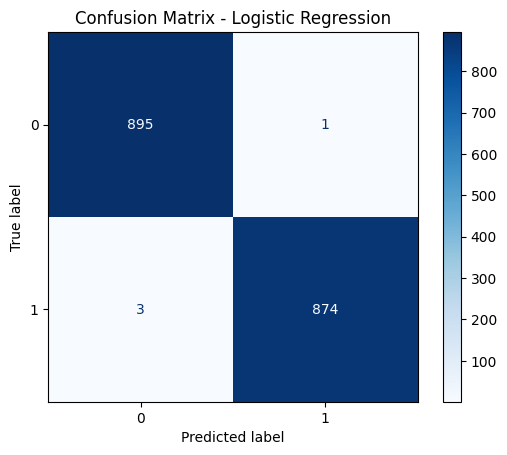

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Logistic Regression # for val data
cm = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



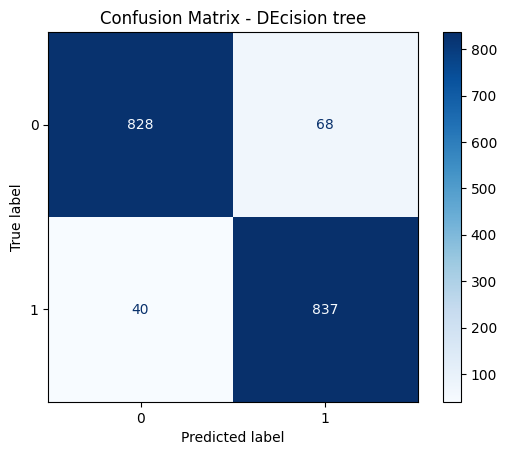

In [18]:
cm = confusion_matrix(y_val, predictions_dt_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - DEcision tree')
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score


In [20]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Normalize the image (assuming your model expects pixel values in [0, 1])
    img_array = img_array / 255.0
    
    # Add batch dimension (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array


In [32]:
test2 = r"C:\Users\Admin\Downloads\BoneFractureDataset\testing\not_fractured\3.jpg"

test2_image = preprocess_image(test2)
# Reshape the test image to 2D (batch_size, num_features)
test2_image_flattened = test2_image.reshape(1, -1)

In [ ]:
# Path to your test image
test_image_path = r"C:\Users\Admin\Downloads\BoneFractureDataset\testing\fractured\9.jpg"

# Preprocess the image
test_image = preprocess_image(test_image_path)
# Reshape the test image to 2D (batch_size, num_features)
test_image_flattened = test_image.reshape(1, -1)


In [33]:
test_image_features = vgg_model.predict(test_image, verbose=1)
test2_image_features = vgg_model.predict(test2_image, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


In [28]:
# Predict using the trained model
test_image_features_flattened = test_image_features.flatten().reshape(1, -1)
prediction = lr.predict(test_image_features_flattened)

# If you are using a softmax output or probabilities
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [46]:
# Predict using the trained model
test2_image_features_flattened = test2_image_features.flatten().reshape(1, -1)
prediction2 = lr.predict(test2_image_features_flattened)

# If you are using a softmax output or probabilities
predicted_class2 = np.argmax(prediction2)
print(f"Predicted Class: {predicted_class2}")

Predicted Class: 0


In [29]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder on your labels (y_train)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# To see the label mapping
print(label_encoder.classes_)

[0. 1.]


In [30]:
# Check the first few rows of your dataset and see what the labels are
print(y_train[:10])  # Check first 10 training labels


[1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]


In [42]:
test_generator2 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  
    batch_size=10,  # Limit to 10 images toa void multi dim error
    class_mode='binary',  
    shuffle=False  
)
#Get features for the batch of images
X_batch, y_batch = next(test_generator)

# Extract features (the CNN output)
features =vgg_model.predict(X_batch)

# Flatten the features to match the input shape expected by Logistic Regression
X_batch_flattened = features.reshape(features.shape[0], -1)

# Assuming you have already trained your Logistic Regression model (lr)
# Predict using the logistic regression model
predictions = lr.predict(X_batch_flattened)

# Print the predictions
print(predictions)

Found 600 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [43]:
for i, filename in enumerate(test_generator.filenames[:10]):  # Adjust this if you want more images
    predicted_class = predictions[i]  # This will give the predicted class for each image
    print(f"Image: {filename}, Predicted Class: {predicted_class}")

Image: fractured\1-rotated1-rotated1-rotated1.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated1-rotated2.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated1-rotated3.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated1.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated2-rotated1.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated2-rotated2.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated2-rotated3.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated2.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated3-rotated1.jpg, Predicted Class: 0.0
Image: fractured\1-rotated1-rotated3-rotated2.jpg, Predicted Class: 0.0


In [ ]:
#Understood that 0 is for fracture and 1 is for not a  fracture